# Particle filter on a road network

Let us do a simple road network with 6 intersections where each road is two-way

```
4-------5-------6
|       |       |
|       |       |
|       |       |
1-------2-------3
```

There are really 14 directed edges:
$$
e_i \in \{(1,2),(1,4),(2,1),(2,3),(2,5),(3,2),(3,6),(4,1),(4,5),(5,4),(6,3),(6,5)\}
$$

Each edge shall also have a length associated with it. For simplicity, we shall make each edge of length 100m. A vehicle travelling along an edge shall have a position and velocity associated with it. 

In [8]:
from __future__ import division

%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy as np
from scipy.stats import norm
import scipy.io as sio
import matplotlib as mpl
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc
from scipy.stats import multivariate_normal as mvn
from math import atan2
from tqdm import tqdm_notebook as tqdm
import copy
import datetime

from IPython.display import display, Markdown, Latex

In [9]:
class Roadmap:
    """A class to represent a road network"""
    
    def __init__(self, nodes, edges, bidirectional=True):
        """
        nodes: list of tuples (x, y). Defines the cartesian location of each intersection.
        edges: list of tuples (start, end). Defines the roads between intersections. Each edge is 
            unidirectional.
        """
        self.graph = {node : {} for node in nodes}
        self.minXY = list(map(min, zip(*nodes)))
        self.maxXY = list(map(max, zip(*nodes)))
        for edge in edges:
            a = nodes[edge[0]]
            b = nodes[edge[1]]
            dist = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
            self.graph[a][b] = dist
            if bidirectional:
                self.graph[b][a] = dist
                
        self._total_len = 0.0
        for dests in self.graph.values():
            self._total_len += np.sum(list(dests.values()))
    
    def get_bounds(self):
        return self.minXY[0], self.maxXY[0], self.minXY[1], self.maxXY[1]
    
    def get_nearest_waypoint(self, pos):
        waypoint = None
        min_dist = 999999999
        for node in self.graph:
            dist = (pos[0] - node[0])**2 + (pos[1] - node[1])**2
            if dist < min_dist:
                min_dist = dist
                waypoint = node
        return waypoint

    def get_next_waypoint(self, waypoint, psi):
        options = self.graph[waypoint].keys()
        next_wp = random.choice(options)
        next_psi = atan2(next_wp[0] - waypoint[0], next_wp[1] - waypoint[1])
        diff_angle = abs(((next_psi - psi) + np.pi) % (2*np.pi) - np.pi)
        return next_wp

    def get_loc(self, state):
        """Returns the (x,y) location of a position along an edge
        
        edge -- tuple containing the (x,y) coordnates of 
                the beginning and ending nodes of the edge
        pos  -- value between 0 and 1 indicating the distance along the edge
        """
        
        edge = state[0]
        pos = state[1]
        
        try:
            self.graph[edge[0]][edge[1]]
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
            
        loc = (pos*edge[1][0] + (1-pos)*edge[0][0],
               pos*edge[1][1] + (1-pos)*edge[0][1])
        return loc
#         raise NotImplementedError
    
    @property
    def total_length(self):
        return self._total_len
    
    def visualize(self, ax):
        edges = []
        for a in self.graph:
            edges += [(a, b) for b in self.graph[a]]
        lc = mc.LineCollection(edges, colors=[(0,0,0,1)])
        ax.add_collection(lc)
        

In [10]:
class Particle(object):
    def __init__(self, roadmap, v0, dt, e0=None, x0=None, sigma=0.1):
        """A Particle contains the state and dynamic model of one hypothesis of a vehicle location.
        
        The particle's state consists of which road segment the vehicle is on and how far along 
        that road segment the vehicle is, on a scale of 0 to 1. The particle also stores its 
        nominal velocity and noise characteristics.
        
        roadmap -- object containing a graph describing the network of roads
        
        """
        # current edge
        self._roadmap = roadmap
        if e0 is None:
            a = random.choice(list(self._roadmap.graph.keys()))
            b = random.choice(list(self._roadmap.graph[a].keys()))
            self._e = (a, b)
        else:
            self._e = e0
        self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
        # current position on edge 
        if x0 is None:
            self._x = random.random()
        else:
            self._x = x0
        self._v = v0
        self._sigma = sigma
        self._dt = dt
        
    def predict(self):
        """Propogate the particle's state based on its dynamics and the roadmap
        
        When a particle is updated, it moves along the road segment by v0*dt, normalized by the 
        length of its current road. If it reaches the end of the road (x >= 1), it queries the
        roadmap for other roads that connect to the current intersection and chooses one at
        random.
        """
        n = np.random.normal(scale=self._sigma)
        self._x += (self._v + n)*self._dt/self._e_len
        
        if self._x >= 1.:
            dest_list = list(self._roadmap.graph[self._e[1]].keys())
            # no U-turns
            dest_list.remove(self._e[0])
            self._e = (self._e[1], random.choice(dest_list))
            self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
            self._x = 0.
            
        return self.state
        
    @property
    def state(self):
        return (self._e, self._x)
    
    @state.setter
    def state(self, new_state):
        e = new_state[0]
        x = new_state[1]
        try:
            self._roadmap.graph[e[0]][e[1]]
            self._e = e
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
        if x < 0.:
            self._x = 0.
        elif x > 1.:
            self._x = 1.
        else:
            self._x = x
        
    @property
    def loc(self):
        return self._roadmap.get_loc(self.state)

In [11]:
# vectorized particle filter
class PF(object):
    def __init__(self, roadmap, num_particles, dt, v0=10., sigma=4, x0=None, P_fa=0.1, P_miss=0.05):
        self._roadmap = roadmap
        self._N = num_particles
        self._v0 = v0
        # particle shape
        ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
        self.X = np.ndarray(shape=(self._N, 12))
        
        if x0 is None:
            #uniformly distribute the particles on the roadway
            for i in range(self._N):
                a = random.choice(list(self._roadmap.graph.keys()))
                b = np.array(random.choice(list(self._roadmap.graph[a].keys())))
                a = np.array(a)
                vector = b - a
                loc = a + vector * random.random()
                distance = np.linalg.norm(vector)
                vector = vector/distance
                self.X[i] = [loc[0], loc[1], v0, a[0], a[1], b[0],
                                      b[1], vector[0], vector[1], distance, sigma, 1/self._N]

        else:
            raise NotImplementedError

        self.best = self.X[0]
        self._dt = dt
        self._P_fa = P_fa
        self._P_miss = P_miss
    
    def get_particle_distance_from_target(self, loc, acceptable_distance):
        avg = 0
        num_in_distance = 0
        dist = np.linalg.norm(self.X[:,0:2] - loc, axis=1)
        num_in_distance = len(np.where(dist < acceptable_distance)[0])
        avg = np.average(dist)
        return avg, num_in_distance

    def get_max_particle_density(self):
        overall_avg = 0
        min_avg = 9999999999
        for i in range(len(self.X)):
            dist = np.linalg.norm(self.X[:,0:2] - self.X[i,0:2], axis=1)
            avg_dist = np.average(dist)
            overall_avg += avg_dist
            if avg_dist < min_avg:
                min_avg = avg_dist
        return overall_avg, min_avg

    def get_edge_particle_density(self):
        edges = {}
        edges_present, count = np.unique(self.X[:, 3:7], return_counts=True, axis=0)
        for i in range(len(edges_present)):
            start_edge = (edges_present[i][0], edges_present[i][1])
            end_edge = (edges_present[i][2], edges_present[i][3])
            edges[(start_edge, end_edge)] = count[i]
        return edges

    def get_measurement_likelihood(self, z, R):
        return np.sum(mvn.pdf(self.X[:,:2], z, R))

    def low_var_sample(self):
        M = self._N
        r = np.random.uniform(0,1/M)
        c = self.X[0,11]
        new_particles = np.zeros_like(self.X)
        i = 0
        last_i = 1
        unique = 1
        insert_index = 0
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + self.X[i,11]
            new_particles[insert_index] = copy.deepcopy(self.X[i])
            insert_index += 1
            if last_i != i:
                unique += 1
            last_i = i
        self.X = new_particles
        return unique

    def predict(self, timestep=1):
#         old_particles = deepcopy(self.X)
        n = np.random.normal(scale=self.X[:,10:11])
        loc = self.X[:,0:2]
        vector = self.X[:,7:9]
        speed = self.X[:,2:3]
        loc[...] += vector * ((speed + n) * timestep * self._dt)
        update_vector = np.linalg.norm(self.X[:,0:2] - self.X[:,3:5], axis=1) \
            > self.X[:,9]

        for i in np.where(update_vector)[0]:
            a = (self.X[i,3], self.X[i,4])
            b = (self.X[i,5], self.X[i,6])

            dest_list = list(self._roadmap.graph[b].keys())
            dest_list.remove(a)
            a = self.X[i,5:7]
            b = np.array(random.choice(dest_list))
            vector = b - a
            distance = np.linalg.norm(vector)
            vector = vector/distance
            self.X[i,0:10] = [a[0], a[1], self._v0, a[0], a[1], b[0],
                           b[1], vector[0], vector[1], distance]
        
    def update(self, z, R, p_fa=None):
        weight_addon = self._P_fa/self._roadmap.total_length
        w = (1. - self._P_fa)*mvn.pdf(self.X[:,0:2], z, R) + weight_addon
        
        
        w = np.log(w)

        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)

        self.best_idx = np.argmax(w)  
        self.best = self.X[self.best_idx]
        self.X[:,11] = w

        unique = self.low_var_sample()

    def neg_update(self, z, radius):
        self.X[:,11] = 1
        update_vector = np.linalg.norm(self.X[:,0:2] - z, axis=1) < radius
        self.X[update_vector,11] = self._P_miss
        self.X[:,11] /= np.sum(self.X[:,11])
        unique = self.low_var_sample()


In [12]:
class Agent(object):
    def __init__(self, center, width, height, period, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self.pos = np.array(self._c)
        self._dt = dt
        self._t = 0
        self._period = period
        self._sc_agent = None
        self._sc_fov = None
        self.fov = fov
        
    def update(self):
        self._t += self._dt
        self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
                             self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
        if self._sc_agent is not None:
            self.update_plot()
    
    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]
        

## Single Target Simulation ##

In [13]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (0.,100.), (100.,100.), (200.,100.)]
# edges = [[i[0], i[1]],
#          [i[0], i[3]],
#          [i[1], i[2]],
#          [i[1], i[4]],
#          [i[2], i[5]],
#          [i[3], i[4]],
#          [i[4], i[5]]]

edges = [(0, 1),
         (0, 3),
         (1, 2),
         (1, 4),
         (2, 5),
         (3, 4),
         (4, 5)]

# initialize the roadmap
r = Roadmap(i, edges)

<IPython.core.display.Javascript object>


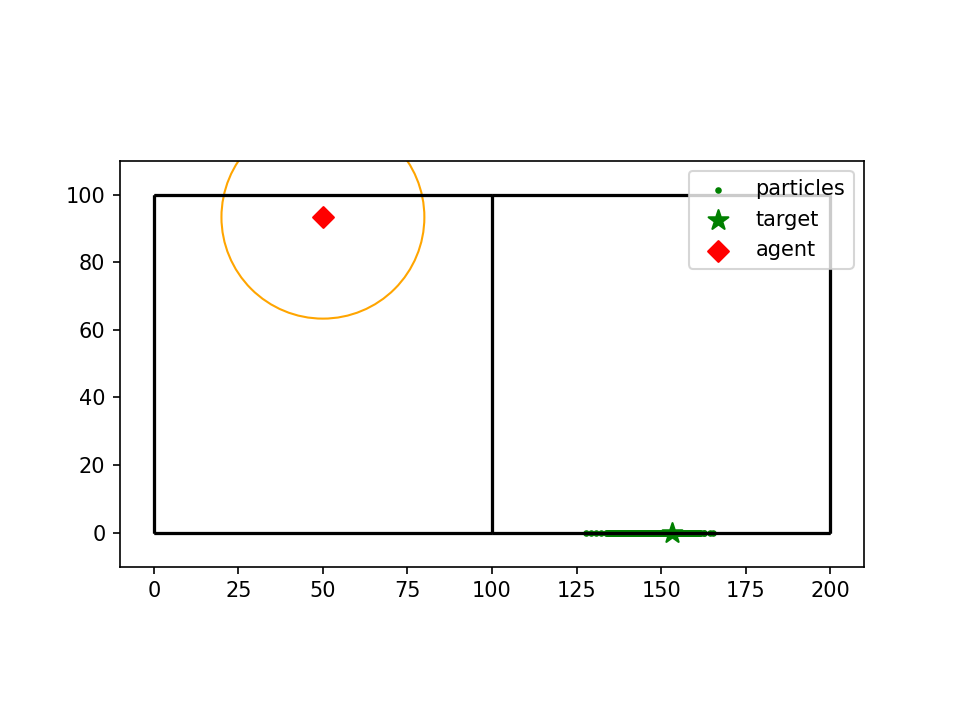

89.55918860435486


In [15]:
# create 100 particles on the roads
N = 1000
dt = 0.1
# pf = PF(r, N, dt=dt, v0=10, sigma=5)
pf = PF(r, N, dt=dt, v0=10, sigma=4)

R = 10*np.eye(2)

target = Particle(r, v0=10, dt=dt, sigma=3)

agent = Agent(center=(100, 50), width=100, height=50, period = 30, dt=dt)

# lc = mc.LineCollection(edges, colors=[(0,0,0,1)])

fig, ax = plt.subplots()
# ax.add_collection(lc)

r.visualize(ax)

x0 = pf.X[:,0]
y0 = pf.X[:,1]
# for p in pf.X:
#     loc = r.get_loc(p.state)
#     x0.append(loc[0])
#     y0.append(loc[1])

# sc = ax.scatter([40, 110], [30, 10])
sc = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
loc = r.get_loc(target.state)
sc_target = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')
agent.init_plot(ax)
ax.legend()
#ax.plot([50, 60], [50, 50], marker='o', ls='None')
minX,maxX,minY,maxY = r.get_bounds()
ax.set_xlim(minX-10, maxX+10)
ax.set_ylim(minY-10, maxY+10)
ax.set_aspect('equal')
# plt.plot([0,1,1,2])
# plt.show()
fig.canvas.draw()
start = time.time()
Ts = dt
tic = start
# update the scenario
for i in range(int(200/Ts)):
# for i in range(1000):
    pf.predict()
    target.predict()
    dist = np.linalg.norm(target.loc - agent.pos)
#     print(dist)
    if i % int(1/Ts) == 0 and i != 0:
        if dist < agent.fov:
            z = mvn.rvs(target.loc, R)
            pf.update(z, R)
        else:
            pf.neg_update(agent.pos, radius=30)
#     locs = [p.loc for p in pf.X]
    locs = pf.X[:,:2]
    sc.set_offsets(locs)
    sc_target.set_offsets(target.loc)
    agent.update()
# sc.set_offsets([[50, 50], [130, 30]])
    fig.canvas.draw()
    toc = time.time()
    dur = toc - tic
#     if Ts > dur:
#         time.sleep(Ts - dur)
#     else:
#         print("No time to sleep! %f"%dur)
    tic = toc
dur = time.time() - start
print(dur)

In [16]:
import scipy.io as sio

roads = []
for a in r.graph:
    roads += [(a, b) for b in r.graph[a]]

roads = np.array(roads)


sio.savemat('single_target.mat', {'roads':roads, 'agent':agent.pos, 'X':pf.X, 'target':target.loc})

## Multiple Targets

Here we need to create a bank of particle filters to track multiple targets with perfect correspondence.

In [17]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (0.,100), (100.,100.), (200.,100.), (0.,200), (100.,200.), (200.,200.)]
edges = [(0, 1),
         (0, 3),
         (1, 2),
         (1, 4),
         (2, 5),
         (3, 4),
         (3, 6),
         (4, 5),
         (4, 7),
         (5, 8),
         (6, 7),
         (7, 8)]

# initialize the roadmap
r = Roadmap(i, edges)

In [18]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (300.,0),
     (0.,100), (100.,100.), (200.,100.), (300.,100.), 
     (0.,200), (100.,200.), (200.,200.), (300.,200.), 
     (0.,300), (100.,300.), (200.,300.), (300.,300.)]
edges = [(0, 1), (0, 4),
         (1, 2), (1, 5),
         (2, 3), (2, 6),
         (3, 7),
         (4, 5), (4, 8),
         (5, 6), (5, 9),
         (6, 7), (6, 10),
         (7, 11),
         (8, 9), (8, 12),
         (9, 10), (9, 13),
         (10, 11), (10, 14),
         (11, 15),
         (12, 13),
         (13, 14),
         (14, 15)]

# initialize the roadmap
r = Roadmap(i, edges)

<IPython.core.display.Javascript object>


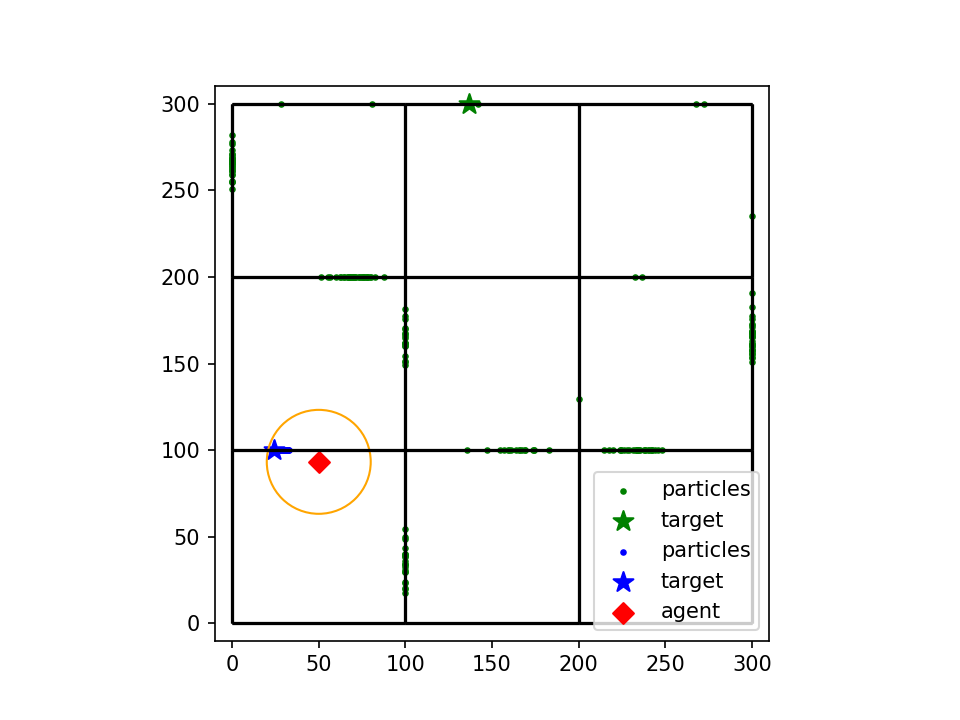

105.41861987113953


In [20]:
# create 100 particles on the roads
N = 200
dt = 0.1

P_fa = 0.02
P_miss = 0.05
pf1 = PF(r, N, dt=dt, v0=10, sigma=4, P_fa=P_fa, P_miss=P_miss)
pf2 = PF(r, N, dt=dt, v0=10, sigma=4, P_fa=P_fa, P_miss=P_miss)

R = 5*np.eye(2)

target1 = Particle(r, v0=10, dt=dt, sigma=2)
target2 = Particle(r, v0=10, dt=dt, sigma=2)

agent = Agent(center=(100, 50), width=100, height=50, period = 30, dt=dt)


fig, ax = plt.subplots()

r.visualize(ax)

x0 = pf1.X[:,0]
y0 = pf1.X[:,1]
# for p in pf.X:
#     loc = r.get_loc(p.state)
#     x0.append(loc[0])
#     y0.append(loc[1])

sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
loc = r.get_loc(target1.state)
sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

x0 = pf2.X[:,0]
y0 = pf2.X[:,1]
# for p in pf.X:
#     loc = r.get_loc(p.state)
#     x0.append(loc[0])
#     y0.append(loc[1])
    
sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
loc = r.get_loc(target2.state)
sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')

agent.init_plot(ax)
ax.legend()
#ax.plot([50, 60], [50, 50], marker='o', ls='None')

minX,maxX,minY,maxY = r.get_bounds()
ax.set_xlim(minX-10, maxX+10)
ax.set_ylim(minY-10, maxY+10)
ax.set_aspect('equal')
# plt.plot([0,1,1,2])
# plt.show()
fig.canvas.draw()
start = time.time()
Ts = dt
tic = start
# update the scenario
for i in range(int(200/Ts)):
# for i in range(1000):
    pf1.predict()
    pf2.predict()
    target1.predict()
    target2.predict()
    dist1 = np.linalg.norm(target1.loc - agent.pos)
#     print(dist)
    if i % int(1/Ts) == 0 and i != 0:
        if dist1 < agent.fov:
            z = mvn.rvs(target1.loc, R)
            pf1.update(z, R)
        else:
            pf1.neg_update(agent.pos, radius=30)
    dist2 = np.linalg.norm(target2.loc - agent.pos)
#     print(dist)
    if i % int(1/Ts) == 0 and i != 0:
        if dist2 < agent.fov:
            z = mvn.rvs(target2.loc, R)
            pf2.update(z, R)
        else:
            pf2.neg_update(agent.pos, radius=25)
    locs1 = pf1.X[:,:2]
    sc1.set_offsets(locs1)
    locs2 = pf2.X[:,:2]
    sc2.set_offsets(locs2)
    sc_target1.set_offsets(target1.loc)
    sc_target2.set_offsets(target2.loc)
    agent.update()
# sc.set_offsets([[50, 50], [130, 30]])
    fig.canvas.draw()
    toc = time.time()
    dur = toc - tic
#     if Ts > dur:
#         time.sleep(Ts - dur)
#     else:
#         print("No time to sleep! %f"%dur)
    tic = toc
dur = time.time() - start
print(dur)

## Unknown Correspondence ##

We will use a RBPF to manage the correspondence. Each particle will contain its own bank of particle filters to track the targets. The history of measurement correspondences will be tracked by the top level RBPF.

The propogation step will be largely the same, with each particle propogating its bank of filters.

The update step will require that the low-level particle filters be able to report the likelihood of a specific measurement occuring for each target. With these probabilities in hand, we can then sample from the distribution to guess which target was the source of the measurement. In the beginning, with all target location particles being uniformly distributed, the correspondences should be chosen with equal probabilities, with convergence coming after several measurements.

In [21]:
class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
       
        
    def update(self, z, R, lone_target, radius=None, p_fa=None):
#         print("updating")
        w = np.zeros(self._N)
        
        

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
    #             print(t)
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

In [22]:
def calc_entropy(r, X, res=5):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    
    h = 0
    for start in r.keys():
        for end in r[start].keys():
            length = r[start][end]
            bin_start = 0.0
            # find the particles on this road segment
            on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
            while bin_start < length:
                in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
                count = np.sum(np.all([on_edge, in_bin], axis=0))
                p = count / (N*M)
                if p > 0:
                    h -= p*np.log(p)
                bin_start += res
    return h
                

In [23]:
class AgentDynamicLookaheadWithEdgeSeparationVectorized(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = 0.9

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        edges = {}
        edge_vals = {}
        
        entropies = [calc_entropy(r.graph, np.array([pf.X])) for pf in pfs]
        norm = np.sum(entropies)
        target_weights = np.array([e/norm for e in entropies])
        target_weights = 1 / (1 + np.exp(-10*(target_weights - 0.5)))
#         print(target_weights)
        
        N = [pf.X.shape[0] for pf in pfs]
        
        for i in range(len(pfs)):
            avg_den, min_den = pfs[i].get_max_particle_density()
            for j in range(len(pfs[i].X)):
                edge = ((pfs[i].X[j][3], pfs[i].X[j][4]),(pfs[i].X[j][5], pfs[i].X[j][6]))
                if edge not in edges:
                    edges[edge] = []
                    edge_vals[edge] = [0,0,0]
                particle = copy.deepcopy(pfs[i].X[j,:])
                particle = np.append(particle, i)
                edges[edge].append(particle)
                edge_vals[edge][0] += 1
                edge_vals[edge][i+1] += 1

        particle_map, best_path, best_value = self.build_particle_map(
            self.path[self.current_dest], edges, target_weights, N, 0, 0, 6)

        self.path.append(best_path[0])
        self.current_dest += 1

    def build_particle_map(self, start, edges, target_weights, N, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}

        best_path = []
        best_value = -1
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            if edge0 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge0])[:,12], np.array(i))
                    val = np.sum(idx)/N[i]
                    value += target_weights[i] * val * (self.discount**lookahead)
            if edge1 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge1])[:,12], np.array(i))
                    val = np.sum(idx)/N[i]
                    value += target_weights[i] * val * (self.discount**lookahead)
            new_edges = {}
            for edge in edges:
                if edge == edge0 or edge == edge1:
#                     value += len(edges[edge][0]) * (self.discount**lookahead)
                    pass
                else:
                    particles = np.array(copy.deepcopy(edges[edge]))
                    particles[:,0:2] = particles[:,0:2] + particles[:,7:9] * (particles[:,2:3] * self._dt)
                    update_vector = np.linalg.norm(particles[:,0:2] - particles[:,3:5]) > particles[:,9]
                    for particle in particles[update_vector]:
                            a = tuple(particle[3:5])
                            b = tuple(particle[5:7])

                            dest_list = list(self._roadmap.graph[b].keys())
                            dest_list.remove(a)
                            a = particle[5:7]
                            b = np.array(random.choice(dest_list))
                            vector = b - a
                            distance = np.linalg.norm(vector)
                            vector = vector/distance
                            particle[0:10] = [a[0], a[1], particle[2], a[0], a[1], b[0],
                                           b[1], vector[0], vector[1], distance]
                            new_edge = ((particle[3], particle[4]), (particle[5], particle[6]))
                            if new_edge not in new_edges:
                                new_edges[new_edge] = []
                            new_edges[new_edge].append(particle)
                    
                    
            graph[edge0], path, path_value = self.build_particle_map(
                destination, new_edges, target_weights, N, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
        return graph, best_path, best_value
    
    def display_particle_map(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]


class AgentRandom(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = .8

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        destinations = list(self._roadmap.graph[self.path[self.current_dest]].keys())
        self.path.append(random.choice(destinations))
        self.current_dest += 1

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]



In [31]:
def sim(rbpf, targets, agent, R, dt, T_end):
    H = []
    fig, ax = plt.subplots()
    r.visualize(ax)

    x0 = rbpf.best[0].X[:,0]
    y0 = rbpf.best[0].X[:,1]
    sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
    loc = r.get_loc(target1.state)
    sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    x0 = rbpf.best[1].X[:,0]
    y0 = rbpf.best[1].X[:,1]
    sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    loc = r.get_loc(target2.state)
    sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')

    agent.init_plot(ax)
    ax.legend()
    #ax.plot([50, 60], [50, 50], marker='o', ls='None')

    minX,maxX,minY,maxY = r.get_bounds()
    ax.set_xlim(minX-10, maxX+10)
    ax.set_ylim(minY-10, maxY+10)
    ax.set_aspect('equal')
    # plt.plot([0,1,1,2])
    # plt.show()
    fig.canvas.draw()
    start = time.time()
    Ts = dt
    tic = start
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    
    # update the scenario
    for i in range(int(100/Ts)):
    # for i in range(1000):
        rbpf.predict()
        target1.predict()
        target2.predict()
        dist1 = np.linalg.norm(target1.loc - agent.pos)
        dist2 = np.linalg.norm(target2.loc - agent.pos)
        if i % int(1/Ts) == 0 and i != 0:
            if (dist1 < agent.fov) != (dist2 < agent.fov):
                if dist1 < agent.fov:
                    z = mvn.rvs(target1.loc, R)
                    rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
                if dist2 < agent.fov:
                    z = mvn.rvs(target2.loc, R)
                    rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
            elif (dist1 < agent.fov) and (dist2 < agent.fov):
                    z = mvn.rvs(target1.loc, R)
                    rbpf.update(z, R, lone_target=False)
                    z = mvn.rvs(target2.loc, R)
                    rbpf.update(z, R, lone_target=False)
            else:
                rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        
        locs1 = rbpf.best[0].X[:,:2]
        sc1.set_offsets(locs1)
        locs2 = rbpf.best[1].X[:,:2]
        sc2.set_offsets(locs2)
        sc_target1.set_offsets(target1.loc)
        sc_target2.set_offsets(target2.loc)
        pfs = rbpf.best
        agent.update(pfs)
        fig.canvas.draw()
        toc = time.time()
        dur = toc - tic
        tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H += [calc_entropy(r.graph, X)]
    return H

def sim_without_plotting(rbpf, targets, agent, R, dt, T_end):

    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    # update the scenario
    for i in tqdm(range(int(T_end/Ts)), leave=False):
        rbpf.predict()
        target1.predict()
        target2.predict()
        dist1 = np.linalg.norm(target1.loc - agent.pos)
        dist2 = np.linalg.norm(target2.loc - agent.pos)
        if i % int(1/Ts) == 0 and i != 0:
            if (dist1 < agent.fov) != (dist2 < agent.fov):
                if dist1 < agent.fov:
                    z = mvn.rvs(target1.loc, R)
                    rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
                if dist2 < agent.fov:
                    z = mvn.rvs(target2.loc, R)
                    rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
            elif (dist1 < agent.fov) and (dist2 < agent.fov):
                    z = mvn.rvs(target1.loc, R)
                    rbpf.update(z, R, lone_target=False)
                    z = mvn.rvs(target2.loc, R)
                    rbpf.update(z, R, lone_target=False)
            else:
                rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        pfs = rbpf.best
        agent.update(pfs)
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H += [calc_entropy(r.graph, X)]
    return H

/tmp/ipykernel_12273/3481836556.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_runs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_12273/120931602.py:82: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(int(T_end/Ts)), leave=False):


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/tmp/ipykernel_12273/1002144902.py:53: RuntimeWarning: invalid value encountered in true_divide
  l = l/np.sum(l)


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


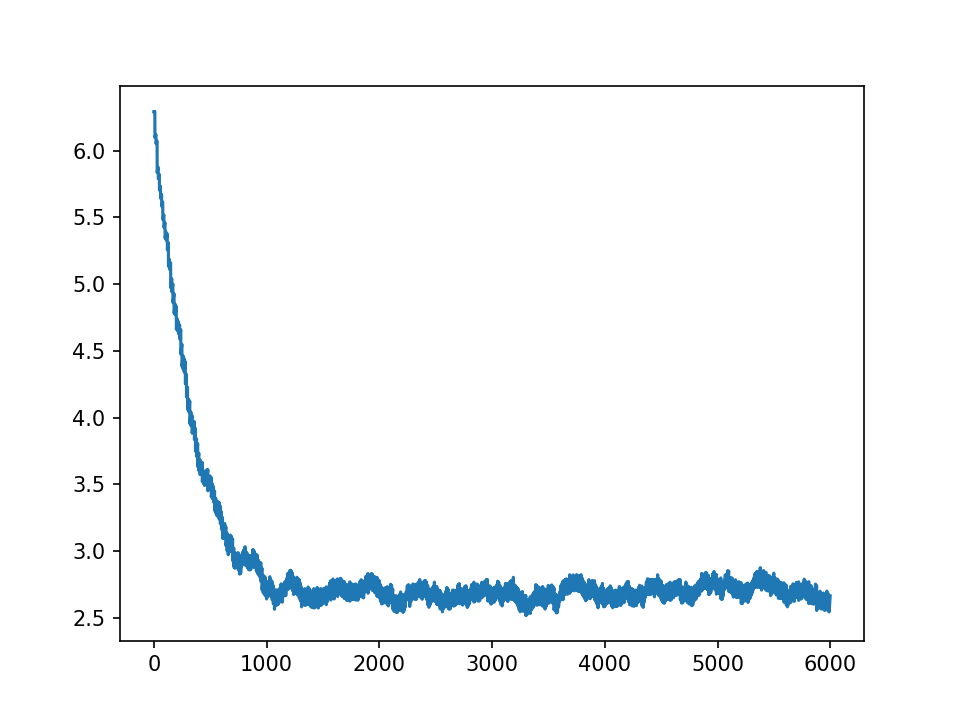

FileNotFoundError: [Errno 2] No such file or directory: 'data/dynamic_lookahead_N-500_T-600_MC-200__2021-09-07 07:47:27.877860.mat'

In [32]:
N = 500
dt = 0.1
T_end = 600
num_runs = 200

P_fa = 0.02
P_miss = 0.05
pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':10, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
R = 5*np.eye(2)
H = []

for i in tqdm(range(num_runs)):
    try:
        rbpf = RB_PF(r, 10, 2, pf_args)

        target1 = Particle(r, v0=10, dt=dt, sigma=2)
        target2 = Particle(r, v0=10, dt=dt, sigma=2)
        targets = [target1, target2]

        agent = AgentDynamicLookaheadWithEdgeSeparationVectorized((100, 60), 100, 50, 40, 30, r, dt=dt)
#         agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

        H += [sim_without_plotting(rbpf, targets, agent, R, dt, T_end)]
#         H += [sim(rbpf, targets, agent, R, dt, T_end)]
    except:
        pass

h = np.mean(H, axis=0)
fig, ax = plt.subplots()
ax.plot(h)
f_name = 'data/dynamic_lookahead_N-{}_T-{}_MC-{}__{}.mat'.format(N, T_end, num_runs, str(datetime.datetime.now()))
sio.savemat(f_name, {'H':H})

In [26]:
import datetime
f_name = 'data/dynamic_lookahead_N-{}_T-{}_MC-{}__{}.mat'.format(N, T_end, num_runs, str(datetime.datetime.now()))
sio.savemat(f_name, {'H':H})
h = np.mean(H, axis=0)
fig, ax = plt.subplots()
ax.plot(h)

FileNotFoundError: [Errno 2] No such file or directory: 'data/dynamic_lookahead_N-500_T-600_MC-200__2021-09-06 23:26:41.179264.mat'

In [27]:
import scipy.io as sio


sio.savemat('Dynamic_Lookahead_L_N-500_T-600_MC-1.mat', {'H':H})

<IPython.core.display.Javascript object>


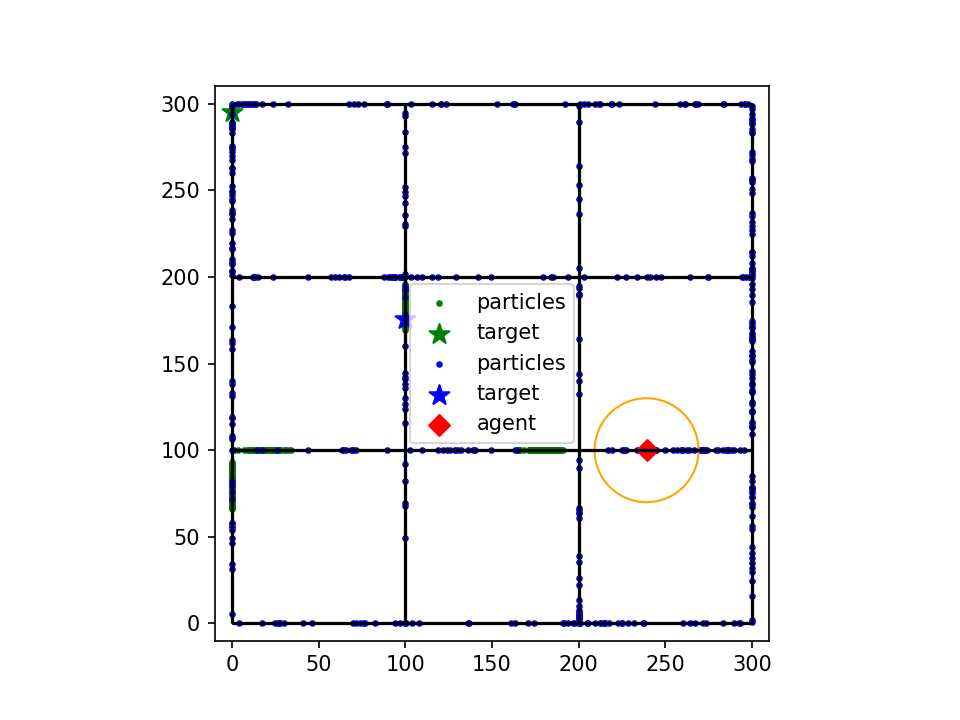

In [28]:
# s = 4
# np.random.seed(s)
# random.seed(s)

N = 500
dt = 0.1
T_end = 600
num_runs = 20

P_fa = 0.02
P_miss = 0.05
pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':10, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
R = 5*np.eye(2)
H = []

rbpf = RB_PF(r, 10, 2, pf_args)

target1 = Particle(r, v0=10, dt=dt, sigma=2)
target2 = Particle(r, v0=10, dt=dt, sigma=2)
targets = [target1, target2]

agent = AgentDynamicLookaheadWithEdgeSeparationVectorized((100, 60), 100, 50, 40, 30, r, dt=dt)
# agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

H += [sim(rbpf, targets, agent, R, dt, T_end)]

<IPython.core.display.Javascript object>


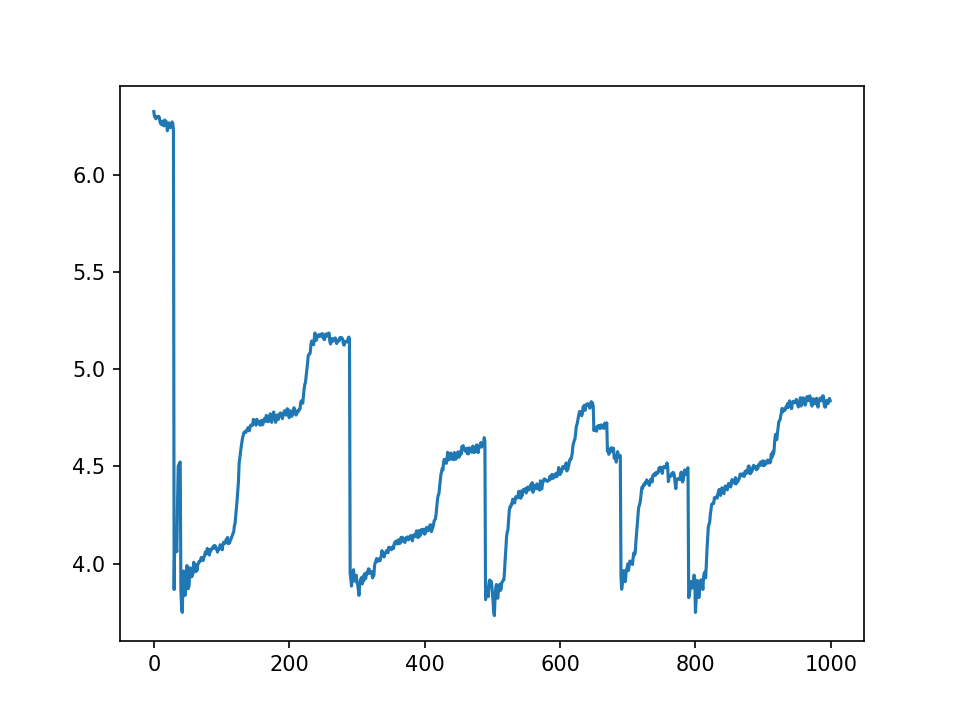

In [29]:
fig, ax = plt.subplots()
ax.plot(H[0])

In [30]:
import scipy.io as sio

roads = []
for a in r.graph:
    roads += [(a, b) for b in r.graph[a]]

roads = np.array(roads)

X1 = rbpf.best[0].X
X2 = rbpf.best[1].X

sio.savemat('multi_target.mat', {'roads':roads, 'agent':agent.pos, 'X1':X1, 'X2':X2, 
                                 'target1':target1.loc, 'target2':target2.loc})